# Семинар 7. Завершение ФП и переход к ООП

На этом семинаре мы закончим обсуждение элементов функционального программирования и начнем говорить про ООП

Функциональные элементы

1. Обратная сторона лямбды

ООП

1. Базовые понятия
2. Наследование, Инкапсуляция, Полиморфизм
2. Атрибуты
4. Методы

### Обратная сторона лямбды

Подоплека: когда мы работаем со списками, часто встает задача найти первый элемент, удовлетворяющий определенному условию. Обычно эта задача решается при помощи конструкции наподобие следующей:

In [ ]:
def first_positive_number(numbers):
    for n in numbers:
        if n > 0:
    return n

В функциональном стиле можно переписать так:

In [ ]:
def first(predicate, items):
    for item in items:
        if predicate(item):
    return item

first(lambda x: x > 0, [-1, 0, 1, 2])

In [ ]:
# Less efficient
list(filter(lambda x: x > 0, [-1, 0, 1, 2]))[0]
# Efficient
next(filter(lambda x: x > 0, [-1, 0, 1, 2]))

Вопрос: какую вы видите проблему с первым вариантом?

Можно немного упростить себе жизнь, воспользовавшись небольшой полезной библиотекой first:

In [ ]:
from first import first

a = first([0, False, None, [], (), 42])
b = first([-1, 0, 1, 2])
c = first([-1, 0, 1, 2], key=lambda x: x > 0)
print(a, b, c)

Здесь мы используем именованный аргумент `key` с тем, чтобы передать в него функцию, которая поочередно оценивает каждый аргумент на соответствие условию.

Как можно увидеть, в семинаре мы повсеместно используем для подобных случаев `lambda`. Вообще говоря, `lambda` была включена в Python в первую очередь для удобства использования функциональных `map()` и `filter()`, который в противном случае потребовали бы определять новую функцию каждый раз когда нужно проверить какое-то новое условие.

In [ ]:
import operator
from first import first

def greater_than_zero(number):
    return number > 0

first([-1, 0, 1, 2], key=greater_than_zero)

Код выше работает аналогично предыдущей ячейке, но он гораздо более громоздкий. Если, например, нам понадобится найти первое число в последовательности, которое превосходит, скажем, 42, то нам бы пришлось определять соответствующую отдельную функцию вместо того, чтобы определить ее в одной строке с вызовом `first`.

Несмотря на всю полезность в подобных ситуациях, `lambda` не лишена проблем. Самое очевидное, мы не можем таким образом передать в ключ функцию длиной более одной строчки кода. Однако означает ли это, что в этой ситуации у нас нет другого выхода, кроме как определять отдельную функцию? Не совсем.

`functools.partial` предоставляет альтернативу лямбда-выражению, причем даже более гибкую. Эта конструкция позволяет создать функцию-обертку с интересной особенностью: вместо того, чтобы менять поведение функции, мы взамен меняем аргументы, которые она получает на вход. Например:

In [ ]:
from functools import partial
from first import first

def greater_than(number, min=0):
    return number > min

first([-1, 0, 1, 2], key=partial(greater_than, min=42))

Теперь наша функция `greater_than` по умолчанию работает как прежняя, но вдобавок мы можем указать значение, с которым мы сравниваем передаваемый в нее аргумент. В данном случае, мы передаем в `functools.partial` нашу исходную функцию и значение, которым мы переопределим `min`, и в результате получим новую функцию, которая сравнивает числа на входе с 42, ровно как мы и хотели бы. Другими словами, мы можем задать функцию, и затем кастомизировать ее при помощи `functools.partial` так, как нам необходимо в данной ситуации.

Строго говоря, в данном конкретном случае наша запись все еще избыточна, ведь все, что мы делаем, это сравнение двух чисел. В Питон присутствует специальный модуль `operator` для подобного рода простых операций:

In [ ]:
import operator
from functools import partial
from first import first

first([-1, 0, 1, 2], key=partial(operator.le, 0))

Как мы можем убедиться, `functools.partial` работает и с позиционными аргументами тоже. В данном примере `operator.le(a, b)` принимает на вход два числа и возвращает булево значение в зависимости от того, больше или равно первое второму или нет. Ноль, который мы передаем в `functools.partial`, уходит в переменную `a`, в то время как то, что уходит в функцию, которую мы получаем на выходе из `functools.partial`, уходит в `b`. Таким образом, используя `le` (а не `ge`, как могло бы показаться), наш пример работает должным образом без необходимости в лямбда-выражении и задании каких-либо дополнительных функций.

`functools.partial` особенно полезна в качестве замены `lambda` - которую, к слову сказать, даже планировали убрать из третьей версии Пайтон! - и считается предпочтительной альтернативой. Лямбда-выражения являются некоторой аномалией ввиду ограничения на длину в одну стоку. С другой стороны, `functools.partial` предоставляет удобную обертку вокруг исходной функции.

In [ ]:
from functools import partial
binStrToInt = partial(int, base=2)
print(binStrToInt('10010'))

Вообще говоря, модуль `itertools` в составе Python Standard Library содержит целый ряд полезных функций, которые неплохо держать в уме. Очень часто можно встретить примеры, когда разработчики прописывают свои версии данных функций... называя вещи своими именами, изобретают велосипед, когда есть отличные готовые реализации:

• `chain(*iterables)` итерация по элементам перечисляемого объекта без явного построения промежуточного списка всех элементов<br>
• `combinations(iterable, r)` генерирует все комбинации длины `r` из данного перечисляемого объекта<br>
• `compress(data, selectors)` применяет булеву маску из `selectors` к данным и возвращает только те значения из них, где соответствующие элемент селектора истинен<br>
• `count(start, step)` генерирует бесконечную последовательность значений, начиная со `start` и увеличиваясь на `step` на каждом вызове<br>
• `cycle(iterable)` циклически перебирает элементы в перечисляемом объекте<br>
• `dropwhile(predicate, iterable)` отфильтровывает элементы перечисляемого объекта с начала и до момента когда предикат оценится как ложный<br>
• `groupby(iterable, keyfunc)` создает итератор, который группирует элементы по результату, который возвращает на них функция `keyfunc`<br>
• `permutations(iterable[, r])` возвращает последовательные перестановки элементов перечисляемого объекта длины `r`<br>
• `product(*iterables)` возвращает перечисляемый объект декартова произведения перечисляемых объектов без задействования вложенных циклов<br>
• `takewhile(predicate, iterable)` возвращает элементы перечисляемого объекта с начала и до момента когда предикат оценится как ложный<br>

Наибольшую мощь эти функции приобретают в комбинации с модулем `operator`; сочетание `itertools` и `operator` может заменить собой `lambda` практически во всех ситуациях:

In [ ]:
import itertools

a = [{'foo': 'bar'}, {'foo': 'bar', 'x': 42}, {'foo': 'baz', 'y': 43}]

import operator

print(list(itertools.groupby(a, operator.itemgetter('foo'))))
[(key, list(group)) for key, group in list(itertools.groupby(a, operator.itemgetter('foo')))]

В данном случае можно было бы воспользоваться конструкцией `lambda x: x['foo']`, однако использование `operator` позволяет совсем отказаться от лямбда-выражения.

# Элементы ООП

Объектно-ориентированное программирование - парадигма, которая организует код в объекты. Используя полиморфизм, инкапсуляцию и наследование можно создавать объекты, которые модифицируют свое поведение в зависимости от контекста в логичной манере, скрывают внутренние детали реализации, и могут быть удобным образом переиспользованы и расширены в плане функциональности. 

Надо понимать, что Пайтон не является абсолютным чемпионом в плане поддержки ООП-функционала, но при этом, разумеется, полностью поддерживат эту крайне популярную парадигму, в первую очередь, посредством модели классов, которая позволяет реализовать многие объектно-ориентированные паттерны в высшей степени элегантно. Достаточно сказать, что, вообще говоря, все в этом языке является объектами, включая функции, определения класса и базовые примитивы, такие как строки, а также целые, вещественные и булевы значения.

### Базовые сведения про классы

Классы - ключевая концепция в ООП чтобы определять новые типы объектов. Классы позволяют нам абстрагироваться от имплементации объекта и манипулировать ими более верхнеуровнево через внешний интерфейс.

Формально, классом в Питоне называется описание структуры объекта (полей структуры) и методов (функций) для работы с данными в этой структуре. Проще говоря, набор именованных полей, совокупность которых описывает объект.

In [ ]:
class MyClass:
    pass

Объектом называется экземпляр класса, где поля заполнены конкретными значениями. Объекты находятся в памяти программы и могут изменять свое состояние и выполнять какие-то действия с помощью вызова методов класса для этого объекта

Можно провести аналогию, что класс - это рецепт пирога, в то врема как конкретные пироги, которые вы выпекаете по этому рецепту - это объекты, или экземплары класса. Переменными, или атрибутами класса в торте могут быть сахар, мука и масло, а методами, к примеру, смешать, выпечь и подать на стол.

In [ ]:
my_object = MyClass()
my_object

## Наследование

Наследование - это прием ООП, который позволяет новому классу "наследовать" методы и атрибуты существующего класса. Новый класс называют производным классом или подклассом, в то время как исходный класс называется базовым, супер-классом или надклассом.

Реализуется посредством скобочного синтаксиса.

В примере ниже, `SubClass` наследуется от `SuperClass` и автоматически получает доступ ко всем его методам и атрибутам.

In [ ]:
class SuperClass:
    def __init__(self, name):
        self.name = name

    def print_name(self):
        print(self.name)

class SubClass(SuperClass):
    pass

Подкласс может переопределить или расширить методы надкласса - в примере ниже `SubClass` переопределяет метод `print_name` с тем, чтобы вывести имя строчными.

In [ ]:
class SuperClass:
    def __init__(self, name):
        self.name = name

    def print_name(self):
        print(self.name)

class SubClass(SuperClass):
    def print_name(self):
        print(self.name.upper())

Специальный класс `object` является своего рода корневым классом. Если не указывать надкласс при определении класса, по дефолту в его качестве подставится `object`. Таким образом, де-факто мы используем наследование всегда - явно или косвенно, и самым дальним предком любого класса является `object`.

#### Вызов надкласса при помощи super()

Super() является встроенной функцией, которая позволяет подклассу вызывать методы надкласса. Как правило, используется если нужно расширить или переопределить функционал метода надкласса.

Допустим, у нас есть класс `SuperClass` с методом `print_name`, а также его подкласс `SubClass`, в которым мы хотим расширить функционал `print_name`:

In [ ]:
class SuperClass:
    def __init__(self, name):
        self.name = name

    def print_name(self):
        print(self.name)

class SubClass(SuperClass):
    def print_name(self):
        super().print_name() #вызываем print_name родительского класса
        print("child class")

Часто мы создаем подкласс в том случае, когда нам нужно, чтобы он содержал все, что содержит исходный класс, плюс некоторая дополнительная информация. Например, объект "Друг" будет, в то же время, объектом "Человек", и поэтому должен иметь имя и возраст, но плюс ко всему прочему может иметь дружеское прозвище. В таком случае необходимо переопределить `__init__`; чтобы сделать это элегантно, лучше вызвать инициализатор родительского класса и затем доопределить нужную информацию:

In [ ]:
def __init__(self, name, age, nick):
    super().__init__(name, age)
    self.nickname = nick

NB: Если вы обнаружили, что вводите подкласс в силу того, что вам нужна только часть функциональности надкласса (но не вся), это сильно намекает на то, что ваши классы неплохо бы реорганизовать.

#### Множественное наследование и порядок разрешения методов (Method Resolution Order, MRO)

В Пайтон класс может наследоваться от нескольких классов, перечислив их в определении класса через запятую:

In [ ]:
class SubClass(SuperClass1, SuperClass2):
    pass

В данном случае `SubClass` наследуется как от `SuperClass1`, так и от `SuperClass2`. Когда класс наследуется от нескольких классов, потенциально он может содержать несколько версий одного и того же метода или атрибута. Чтобы разрешить данную неопределенность, Пайтон использует порядок разрешения методов, а именно алгоритм линеаризации C3, который выстраивает классы в однозначную и предсказуемую иерархию.

Что конкретно обеспечивает C3:<br>

• подклассы имеют приоритет над надклассами<br>
• порядок предпочтения между несколькими надклассами - слева направо<br>
• каждый класс фигурирет в порядке разрешения методов лишь в единственном количестве

In [ ]:
class A:
    def method(self):
        print("A")

class B(A):
    pass

class C(A):
    def method(self):
        print("C")

class D(B, C):
    pass

В данном примере класс D наследуется как от B, так и от C, которые, в свою очередь, оба наследуются от А. D - прямой надкласс, в B метод не реализован, A - более дальний надкласс, поэтому вызов метода возвращает "С".

In [ ]:
print(D().method())
print(D.__mro__)

Вообще говоря, Пайтон отличается либеральным подходом в том, что вообще позволяет множественное наследование - хотя стоит отметить, что зачастую к нему все-таки лучше не прибегать. Другие языки зачастую либо не допускают его (например, Котлин), либо накладывают на него серьезные ограничения.

### Инкапсуляция

Инкапсуляция является аспектом парадигмы объектно-ориентированного программирования, согласно которому детали реализации объекта скрываются внутри него, в то время как наружу предоставляется интерфейс для взаимодействия с ним. Иными словами, мы строго разграничиваем имплементацию и взаимодействие/использование.

В Пайтон нет строгой инкапсуляции, но попытка реализовать ее делается при помощи соглашения о "приватных" атрибутах и методах, обозначаемых через одинарное или двойное нижнее подчеркивание. Одно нижнее подчеркивание (например, `_attribute`) означает, что доступ возможен только изнутри самого класса или подклассов. Двойное подчеркивание (например, `__attribute`) означает, что доступ возможен строго изнутри самого класса.

Для атрибутов с двойным нижним подчеркиванием Пайтон изменяет его имя (name-mangling) с тем, чтобы усложнить его вызов извне класса. Для этого к нему добавляется префикс с именем класса (`classname_`)

In [ ]:
class MyClass:
    def __init__(self, value):
        self.__mangled = value
        self._private = value

my_object = MyClass('string')
dir(my_object)

### Полиморфизм

Полиморфизм является еще одним аспектом парадигмы ООП, который позволяет рассматривать объекты разных классов как имеющие в некотором смысле общий надкласс. Это означает, что объекты разных классов можно использовать взаимозаменяемо, при условии что они реализуют одинаковые методы и/или атрибуты. Это позволяет писать гибкий, переиспользуемый и расширяемый код.

Пайтон является динамически-типизированным языком, что позволяет подходить к полиморфизму максимально гибко. Данный гибкий подход получил название "утиная типизация" (duck typing), олицетворяя известный афоризм, что если что-то летает как утка, плавает как утка и крякает как утка, то скорее всего это утка. Другими словами, для программы не столь важен тип вашего объекта - коль скоро вы можете оперировать над объектом посредством некого фиксированного интерфейса, код будет исполнен.

In [ ]:
class Mouse:
    def speak(self):
        return "Squeak"

class Cat:
    def speak(self):
        return "Meow"

class Dog:
    def speak(self):
        return "Woof"

for animal in (Mouse(), Cat(), Dog()):
    animal.speak()

## Атрибуты

Атрибуты - это переменные, ассоциированные с классом или экземпляром класса. В них хранится состояние объекта, и доступ к ним осуществляется через `.`

NB: “Поле”, “атрибут”, “переменная объекта” являются синонимами.

Самый распространенный способ задания атрибутов - как переменные экземпляра класса внутри любого метода класса через `self` (или то, что его заменяет в случае отхода от соглашения). Именно это мы сделали в примере с `__init__`.

Еще примеры:

In [ ]:
my_object = MyClass(5)
my_object.my_value

In [ ]:
my_object.my_value = 10
my_object.my_value

Атрибуты класса - переменные, определенные на уровне класса, а не экземпляра класса. Доступ к ним возможен как через наименование экземепляра класса, так и через наименование самого класса.

In [ ]:
class MyClass:
    class_attribute = "I am a class attribute."

obj1 = MyClass()
obj2 = MyClass()

obj1.class_attribute

In [ ]:
obj2.class_attribute

In [ ]:
MyClass.class_attribute

В случае использования изменяемого типа в качестве атрибута класса важно не попасть в хорошо знакомую нам ловушку:

In [ ]:
class One:
    items = []

a = One()
b = One()

a.items.append(1)
b.items

В отличие от некоторых других поддерживающих ООП языков, в Пайтон объект не обязан иметь фиксированное и неизменяемое количество атрибутов. К объекту можно добавить атрибут путем простого присваивания. Например, `maria.occupation = 'scientist'`. Это затронет лишь экземпляр мария, остальные объекты останутся без изменений. Аналогичным обазом, можно удалить атрибут у объекта при помощи оператора `del`

In [6]:
class Person():
    def __init__(self, age):
        self.age = age

petr = Person(22)        
        
maria = Person(21)
maria.occupation = 'scientist'
print(maria.occupation)

try:
    petr.occupation
except:
    print('not defined')

scientist
not defined


## Методы

В классе мы можем определить связанные с ним методы, определяющие поведение объекта и/или производящие операции над его свойствами. Первым параметром метода всегда является переменная, ссылающаяся на сам класс. По соглашению (и не более того) ее именуют `self`.

In [ ]:
class MyClass:
    def my_method(self):
        print("Hello from my_method!")

In [ ]:
my_object.my_method()

Разумеется, методы могут иметь и другие параметры и возвращать значения, по аналогии с функциями

In [ ]:
class MyClass:
    def add(self, a, b):
        return a + b

my_object = MyClass()
result = my_object.add(2, 3)
result

И вообще, в каком-то смысле методы и есть функции, привязанные к пространству имен класса. В функциональном смысле нет никакой разницы между

In [ ]:
str.join("", ('a', 'b'))

и

In [ ]:
"".join(('a', 'b'))

Наконец, мы можем наследовать подкласс от надкласса (`superclass`).

In [ ]:
class YourClass:
    def subtrace(self, a, b):
        return a - b

class MyClass(YourClass):
    pass

my_object = MyClass()
result = my_object.subtract(2, 3)
result

Вообще, можно заменить, что вызывая `type()` от многих объектов, зачастую возвращается класс

In [ ]:
x = "Hello!"
type(x)

Все эти встроенные в Питон типы имеют свои методы - к примеру, в классе `str` определен `join()`, который принимает в качестве аргумента вызывающий объект, т.е. строку, как `self`, и набор прочих строк, которые соединяются между собой с `self` в качестве разделителя.

In [ ]:
" ".join(('a', 'b', 'c'))

Принимая во внимание данный факт, мы также можем вызвать метод напрямую от класса, задав в таком случае аргумент `self` явно:

In [ ]:
str.join(" ", ('a', 'b', 'c'))

NB: В очередной раз нелишним будет напомнить, что в отличие от многих другим языков, методы и атрибуты в Пайтон нельзя сделать по-настоящему приватными. Нижние подчеркивания в конечном итоге являются лишь соглашениями, и любой пользователь класса по-прежнему может беспрепятственно получить к ним доступ.

### Немного подробнее про self

Вне класса мы обращаемся к объекту и его атрибутам посредством dot-нотации, например, maria.age или maria.say_hi(). Однако внутри класса, объект обращается сам к себе (например, наименовав себя `self`), поэтому мы используем синтаксис `self.age` и `self.say_hi()`.

Еще раз, что такое `self` - это явный первый параметр в каждом методе, и префикс при каждом обращении к объекту. При определении `say_hi()` мы должны передать `self` в качестве первого аргумента; когда мы вызываем `maria.say_hi()`, `maria` является тем аргументом, который затем передается (подставляется) в метод как `self`:

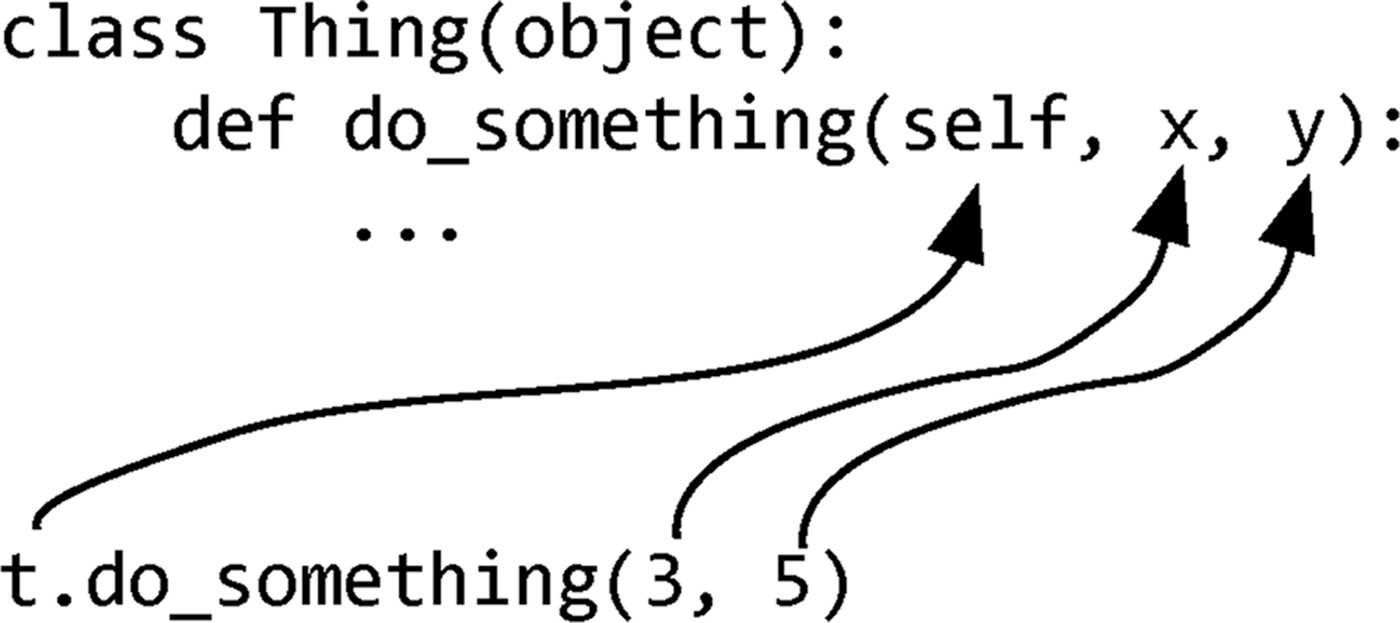

Таким образом, если метод делает отсылку к атрибуту или другому методу внутри своего класса, надо использовать `self`. Любые атрибуты и/или методы без `self` являются лишь локальными переменными метода, в котором они используются.

In [ ]:
def get_older(self):
    self.age += 1
def get_much_older(self, years):
    for i in range(0, years):
        self.get_older()

NB: `self` это всего лишь имя для , и в теории его можно заменить любым другим. Однако, это будет довольно сильное отступление от общепринятых соглашений.

Можно провести сравнение с Java (для тех, кто знаком): эквивалентом self в Java является this со следующими отличиями: (1) this это ключевое слово, в то время как self это наименование переменнной, (2) this, как правило, используется неявно, в то время как `self` необходимо явно прописывать каждый раз.

### `__dunder__` методы

“dunder” (“double underscore”) еще называют “magic методами” - это специальные методы со специальным значением, определяющие особое поведение объектов, например, `__init__` или `__len__`. Пока остановимся подробнее над
`__init__`.

`__init__` вызывается автоматически, когда создается объект, и служит для инициализации атрибутов объекта. Важно: `__init__` **не** является конструктором, это инициализатор, который вызывается автоматически **из** конструктора (когда, собственно, конструируется новый объект).

После того, как мы определили `__init__`, мы можем создать экземпляр класса и передать в него аргументы, посредством вызова класса с соответствующими параметрами. При этом аргументы будут переданы в вызов метода `__init__`, и будут присвоены экземпляру класса `self` как атрибуты.

In [ ]:
class MyClass:
    def __init__(self, my_value):
        self.my_value = my_value

my_object = MyClass(5)
my_object.my_value

In [ ]:
class MyClass:
    def __init__(self, my_value):
        self.my_value = my_value
        
    def my_method(a):
        print("Hello from my_method!")

my_object = MyClass(5)
my_object.my_value
my_object.my_method()

In [ ]:
class MyClass:
    def __init__(self, my_value):
        self.my_value = my_value
        
    def my_method(a):
        print(a.my_value)
        print("Hello from my_method!")

my_object = MyClass(5)
my_object.my_value
my_object.my_method()

### Еще примеры dunder методов

Все классы имеют метод `__str__`, унаследованный от `object`. Переопределить его часто бывает полезно. Если этого не сделать, ваши объекту будут распечатываться в следующем (не очень удобоваримом) виде: 

In [ ]:
<__main__.Friend object at 0x1064728d0> 

Допустим, у нас есть класс `Friend`; тогда для объекта этого класса можно переопределить метод следующим образом:

In [ ]:
def __str__(self): 
    return self.name + "'s age is " + str(self.age)

и условная `print(margo)` выдаст: 

In [ ]:
Margarita's age is 19

По аналогии с `str(x)`, `repr(x)` возвращает строковое представление объекта x, на этот раз определенное посредством метода `__repr__(self)`. Разница в том, что `str(x)` главным обрзом предназначена для вывода через `print(x)` в удобочитаемой человеку форме, в то время как `repr(x)` используется при отладке, и потому должен выдавать детализированный и однозначный результат. Как и `__str__`, `__repr__` это унаследованный от `object` dunder, который мы можем переопределить.

### Dunder методы в общем контексте протоколов языка

Вообще говоря, если копнуть глубже, dunder методы составляют так называемый протокол языка. Когда мы говорим о том, что объект реализует определенный протокол, это означает, что он согласован с определенной частью синтаксиса языка. Что за этим стоит будет проще понять, если пройтись по списку основных протоколов:

Протокол вызова<br>
`__call__()`<br>
Позволяет производить вызовы объектов посредством скобок:<br>
`instance()`

Протоколы дескрипторов<br>
`__set__()`, `__get__()`, and `__del__()`<br>
Задание и модификация атрибуков класса

Контейнерный протокол<br> 
`__contains__`()<br>
Позволяют проверить содержит ли объект какое-либо значение при помощи ключевого слова `in`:<br>
`value in instance`

Протокол итерирования<br>
`__iter__()`<br>
Позволяет итерировать объекты посредством ключевого слова `for`:<br>
`for value in instance:`<br>
`...`

Протокол последовательностей<br>
`__getitem__()`, `__len__()`<br>
Позволяет объектам быть индексироваными посредством синтаксиса квадратных скобок, а также выдавать длину последовательности через встроенную функцию:<br>
`item = instance[index]`<br>
`length = len(instance)`

Каждый доступный в Пайтон оператор имеет свой собственный протокол, и перегрузка операторов происходит посредством переопределения dunder метода этого протокола.

### Заключительный нюанс касательно методов

Мы с вами хорошо помним, что

In [7]:
a = [1, 2, 3] # bind a to the list
b = a # copy a's binding into b
a[0] = 99 # change the list, not the bindings
print(b) # b still bound to the same list,
#but the list is now:

[99, 2, 3]


Когда происходит вызов функции, значения аргументов в вызове связываются с параметрами функции; другими словами, параметрам присваиваются эти значения. Таким образом, любые переданные в функцию изменяемые типы могут быть модифицированы в процессе ее работы:

In [ ]:
def foo(a, b): 
    a[0] = 99 
    b = [7, 8] 

a = [1, 2, 3] 
b = [1, 2, 3] 
    
foo(a, b) 
print(a, b) 
# [99, 2, 3] [1, 2, 3] 

Как общее правило, функции должны возвращать значение, но не менять свои аргументы, при этом методы могут менять свои аргументы. Этим, в частности, объясняется разница между: 

•`obj.sort()` сортирует объект и возвращает `None`, в то время как<br>
•`sorted(obj)` не меняет объект и возвращает отсортированную копию.